# Exercise #3
Tackle the Titanic dataset

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [3]:
train_df = pd.read_csv('../../../../projects/6. TitanicEda/data/train.csv')
test_df = pd.read_csv('../../../../projects/6. TitanicEda/data/test.csv')

In [4]:
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

In [5]:
train_df['title'] = train_df['name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_df['title'] = test_df['name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
train_df['age'] = train_df['age'].fillna(train_df.groupby(['title', 'pclass', 'sex'])['age'].transform('median'))
test_df['age'] = test_df['age'].fillna(train_df.groupby(['title', 'pclass', 'sex'])['age'].transform('median'))

In [6]:
train_df = train_df.drop(columns=['cabin']).copy()
test_df = test_df.drop(columns=['cabin']).copy()

In [7]:
train_df['embarked'] = train_df['embarked'].fillna('S')

In [8]:
test_df['fare'] = test_df['fare'].fillna(train_df['fare'].mean())

In [9]:
train_df = train_df.drop(columns=['passengerid', 'name', 'ticket', 'title']).copy()
test_df = test_df.drop(columns=['passengerid', 'name', 'ticket', 'title']).copy()

In [10]:
train_df_labels = train_df['survived'].copy()
train_df = train_df.drop(columns=['survived']).copy()

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    418 non-null    int64  
 1   sex       418 non-null    object 
 2   age       418 non-null    float64
 3   sibsp     418 non-null    int64  
 4   parch     418 non-null    int64  
 5   fare      418 non-null    float64
 6   embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

train_df_num = train_df.drop(['sex', 'embarked'], axis=1)
num_att = list(train_df_num)
cat_att = ['sex', 'embarked']

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_att),
    ('cat', OneHotEncoder(), cat_att)
])

train_df_prepared = full_pipeline.fit_transform(train_df)
test_df_prepared = full_pipeline.transform(test_df)

In [13]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=42)
svc_clf.fit(train_df_prepared, train_df_labels)

SVC(random_state=42)

In [14]:
from sklearn.metrics import accuracy_score

train_pred = svc_clf.predict(train_df_prepared)
train_accuracy = accuracy_score(train_df_labels, train_pred)
print(f"Train accuracy: {train_accuracy:.2f}")

Train accuracy: 0.84


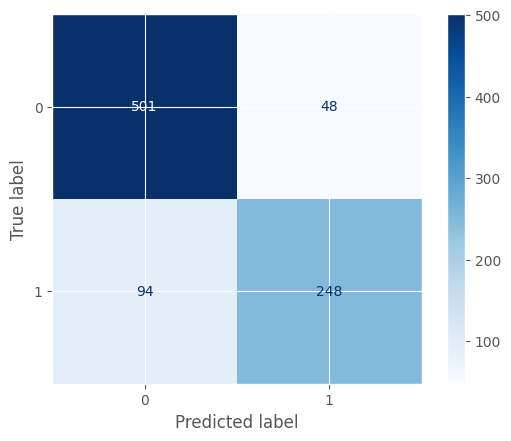

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(train_df_labels, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_clf.classes_)
disp.plot(cmap=plt.cm.Blues)

In [16]:
test_pred = svc_clf.predict(test_df_prepared)
submission_df = pd.DataFrame({'PassengerId': test_df.index + 892, 'Survived': test_pred})
submission_df.to_csv('submission.csv', index=False)

In [17]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    "C": np.logspace(-2, 2, 10),
    "kernel": ["linear", "rbf", "poly"],  
    "gamma": ["scale", 0.1, 1],
    "degree": [2, 3, 4]
}

random_search = RandomizedSearchCV(
    svc_clf, param_dist, 
    n_iter=30,
    cv=5, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1, 
    random_state=42
)

random_search.fit(train_df_prepared, train_df_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=30, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                        'degree': [2, 3, 4],
                                        'gamma': ['scale', 0.1, 1],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring='accuracy', verbose=2)

In [18]:
random_search.best_params_

{'kernel': 'poly',
 'gamma': 'scale',
 'degree': 3,
 'C': np.float64(1.6681005372000592)}

In [19]:
random_search.best_score_

np.float64(0.8316238779737619)

In [20]:
random_model = random_search.best_estimator_

train_pred = random_model.predict(train_df_prepared)
train_accuracy = accuracy_score(train_df_labels, train_pred)
print(f"Train accuracy: {train_accuracy:.2f}")

Train accuracy: 0.85


bro just 0.01 better ...

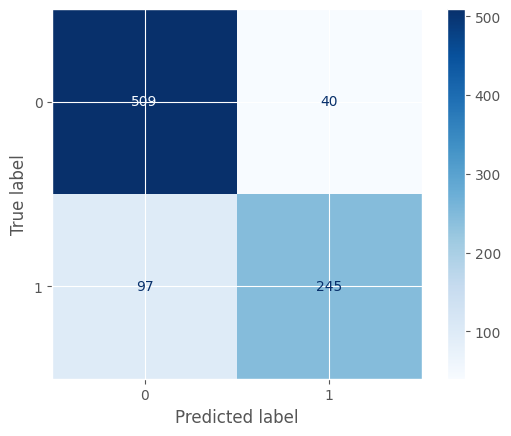

In [21]:
cm = confusion_matrix(train_df_labels, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_model.classes_)
disp.plot(cmap=plt.cm.Blues)

In [22]:
test_pred = random_model.predict(test_df_prepared)
submission_df = pd.DataFrame({'PassengerId': test_df.index + 892, 'Survived': test_pred})
submission_df.to_csv('submission2.csv', index=False)

0.76 on kaggle (worse)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(train_df_prepared, train_df_labels)

KNeighborsClassifier()

In [24]:
train_pred = knn_clf.predict(train_df_prepared)
train_accuracy = accuracy_score(train_df_labels, train_pred)
print(f"Train accuracy: {train_accuracy:.2f}")

Train accuracy: 0.86


In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(knn_clf, train_df_prepared, train_df_labels, cv=10, scoring='accuracy')

array([0.78888889, 0.80898876, 0.71910112, 0.79775281, 0.84269663,
       0.78651685, 0.83146067, 0.79775281, 0.83146067, 0.80898876])

In [26]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(train_df_prepared, train_df_labels)

DecisionTreeClassifier(random_state=42)

In [27]:
train_pred = dt_clf.predict(train_df_prepared)
train_accuracy = accuracy_score(train_df_labels, train_pred)
print(f"Train accuracy: {train_accuracy:.2f}")

Train accuracy: 0.98


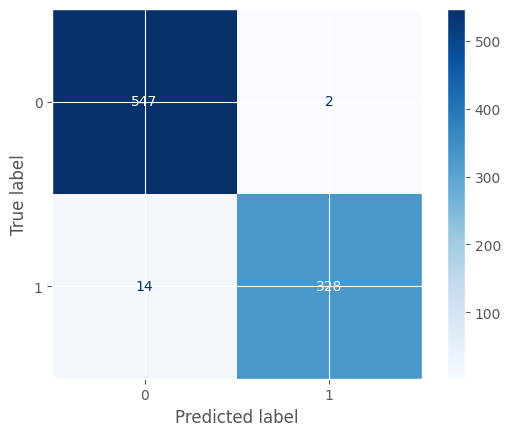

In [28]:
cm = confusion_matrix(train_df_labels, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [29]:
cross_val_score(dt_clf, train_df_prepared, train_df_labels, cv=10, scoring='accuracy').mean()

np.float64(0.782334581772784)

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_df_prepared, train_df_labels)

RandomForestClassifier(random_state=42)

In [31]:
train_pred = rf_clf.predict(train_df_prepared)
train_accuracy = accuracy_score(train_df_labels, train_pred)
print(f"Train accuracy: {train_accuracy:.2f}")

Train accuracy: 0.98


In [32]:
cross_val_score(rf_clf, train_df_prepared, train_df_labels, cv=10, scoring='accuracy').mean()

np.float64(0.813732833957553)

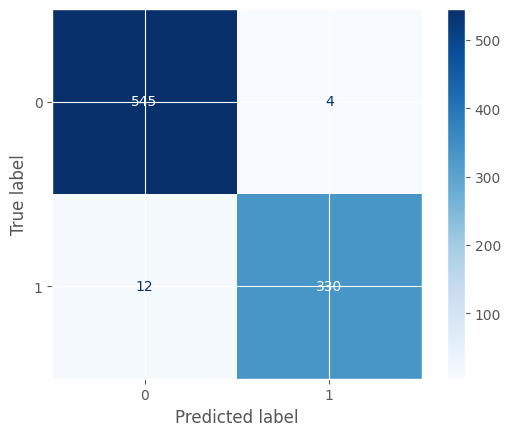

In [33]:
cm = confusion_matrix(train_df_labels, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [34]:
test_pred = rf_clf.predict(test_df_prepared)
submission_df = pd.DataFrame({'PassengerId': test_df.index + 892, 'Survived': test_pred})
submission_df.to_csv('submission4.csv', index=False)

In [38]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_clf.fit(train_df_prepared, train_df_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [39]:
train_pred = xgb_clf.predict(train_df_prepared)
train_accuracy = accuracy_score(train_df_labels, train_pred)
print(f"Train accuracy: {train_accuracy:.2f}")

Train accuracy: 0.97


In [40]:
cross_val_score(xgb_clf, train_df_prepared, train_df_labels, cv=10, scoring='accuracy').mean()

np.float64(0.8137078651685392)

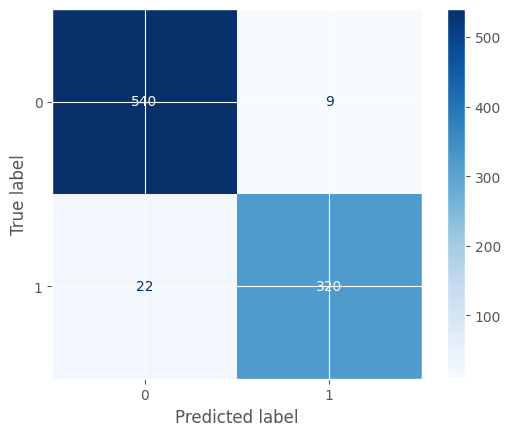

In [41]:
cm = confusion_matrix(train_df_labels, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [42]:
test_pred = xgb_clf.predict(test_df_prepared)
submission_df = pd.DataFrame({'PassengerId': test_df.index + 892, 'Survived': test_pred})
submission_df.to_csv('submission5.csv', index=False)